In [ ]:
import sys
import os
print(os.getcwd())
sys.path.append("..")
from alphabet import load_alphabet
from alphabet import A
import numpy as np
import matplotlib.pyplot as plt
from synthetic import DataGenerator, SynthSettings
from noise import Noise
from unet import UNet
import torch
alphabet = load_alphabet()

/home4/s6019595/dlp


In [2]:
elements_per_class = {cls: len(images) for cls, images in alphabet.items()}
classes = list(elements_per_class.keys())
classes.sort()
counts = list(elements_per_class.values())
print(counts)

[300, 300, 193, 300, 10, 300, 300, 300, 116, 294, 300, 300, 300, 300, 37, 78, 23, 300, 265, 91, 12, 300, 15, 300, 73, 300, 130]


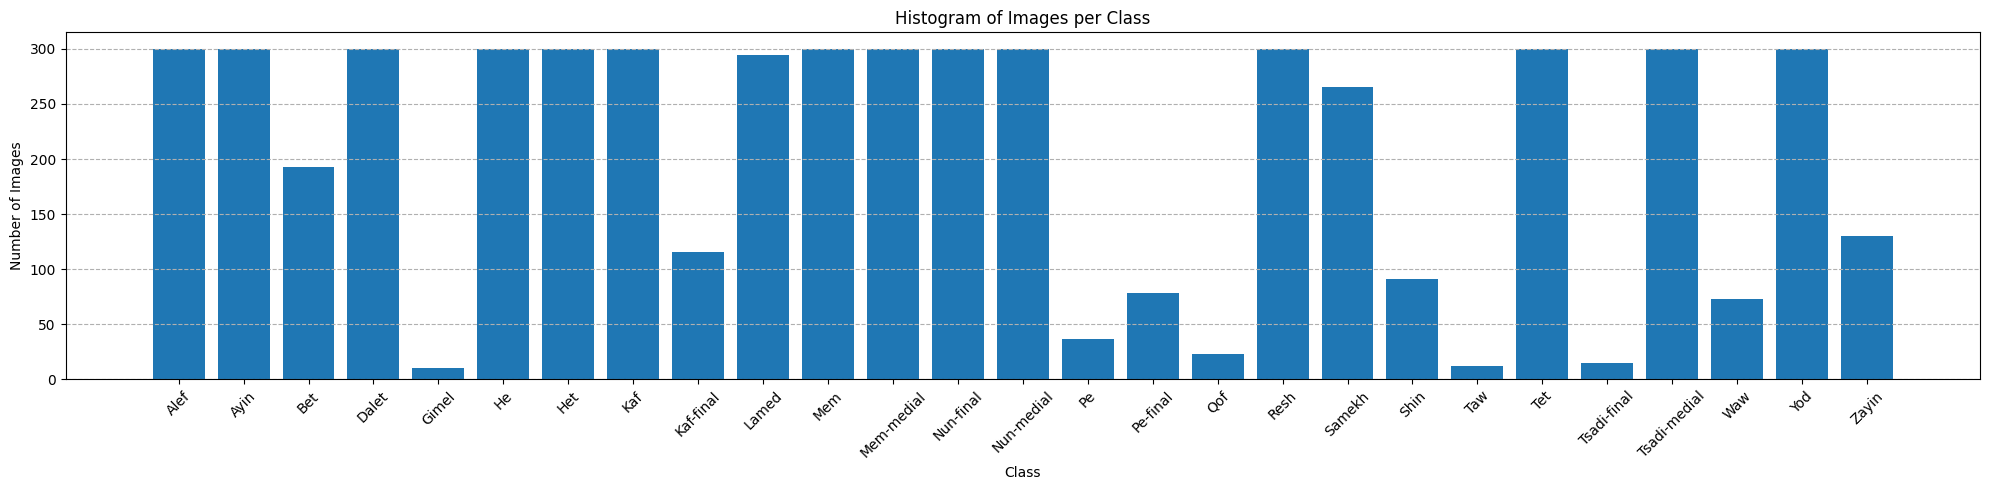

In [3]:
plt.figure(figsize=(20,5))
plt.bar(classes, counts)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Histogram of Images per Class')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

In [3]:

settings = SynthSettings(downscale_factor=0.3)
generator = DataGenerator(settings=settings)
tokens, masks, scrolls = generator.generate_ngram_scrolls(200)

(200, 27, 120, 300)
(200, 120, 300)
109


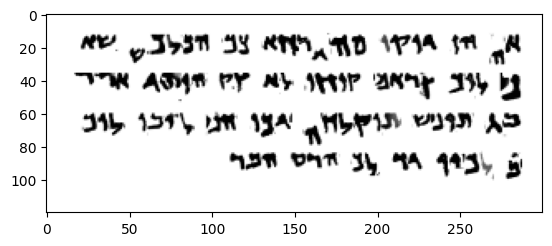

In [4]:
print(masks.shape)
print(scrolls.shape)
plt.imshow(scrolls[0], cmap="gray")
print((tokens[0] > -1).sum())

In [5]:
noiser = Noise(image_size=generator.settings.downscale_size)
noiser.create_masks(5)

In [6]:
dmgd_scrolls = noiser.damage(images=scrolls, strength=0.3)

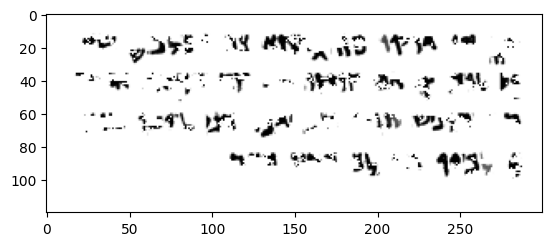

In [7]:
plt.imshow(dmgd_scrolls[0], cmap="gray")

In [8]:
print(scrolls[0].shape)
import os
print(os.getcwd())
model = UNet(num_classes=27)
model.load_state_dict(torch.load("checkpoints/unet_20250422_191317/best_model.pth"))
model.to("cuda")
model.eval()

(120, 300)
/home4/s6019595/dlp


UNet(
  (enc1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (enc4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (bottleneck): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (up4): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2), output_padding=(1, 1))
  (dec4): Sequential(
    (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (up3): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2), output_padding=(0, 1))
  (dec3): Sequential(


In [9]:
img = scrolls[0]  # This is a numpy array, shape: (H, W)
# Convert to tensor and reshape to (1, 1, H, W)
img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to("cuda")


[[-12.366635 -17.017286 -26.356047 ... -21.936075 -19.691137 -16.963322]
 [-21.55873  -29.41908  -34.28654  ... -26.723131 -23.190943 -17.488888]
 [-26.632282 -32.728603 -43.21262  ... -30.653807 -25.655594 -21.318304]
 ...
 [-46.14617  -68.201096 -81.60315  ... -57.484497 -49.7275   -35.209347]
 [-45.759094 -71.22413  -85.17012  ... -61.291492 -54.878178 -33.370644]
 [-27.56416  -43.07745  -53.84092  ... -39.61499  -32.54709  -20.06093 ]]
(27, 120, 300)
(120, 300)


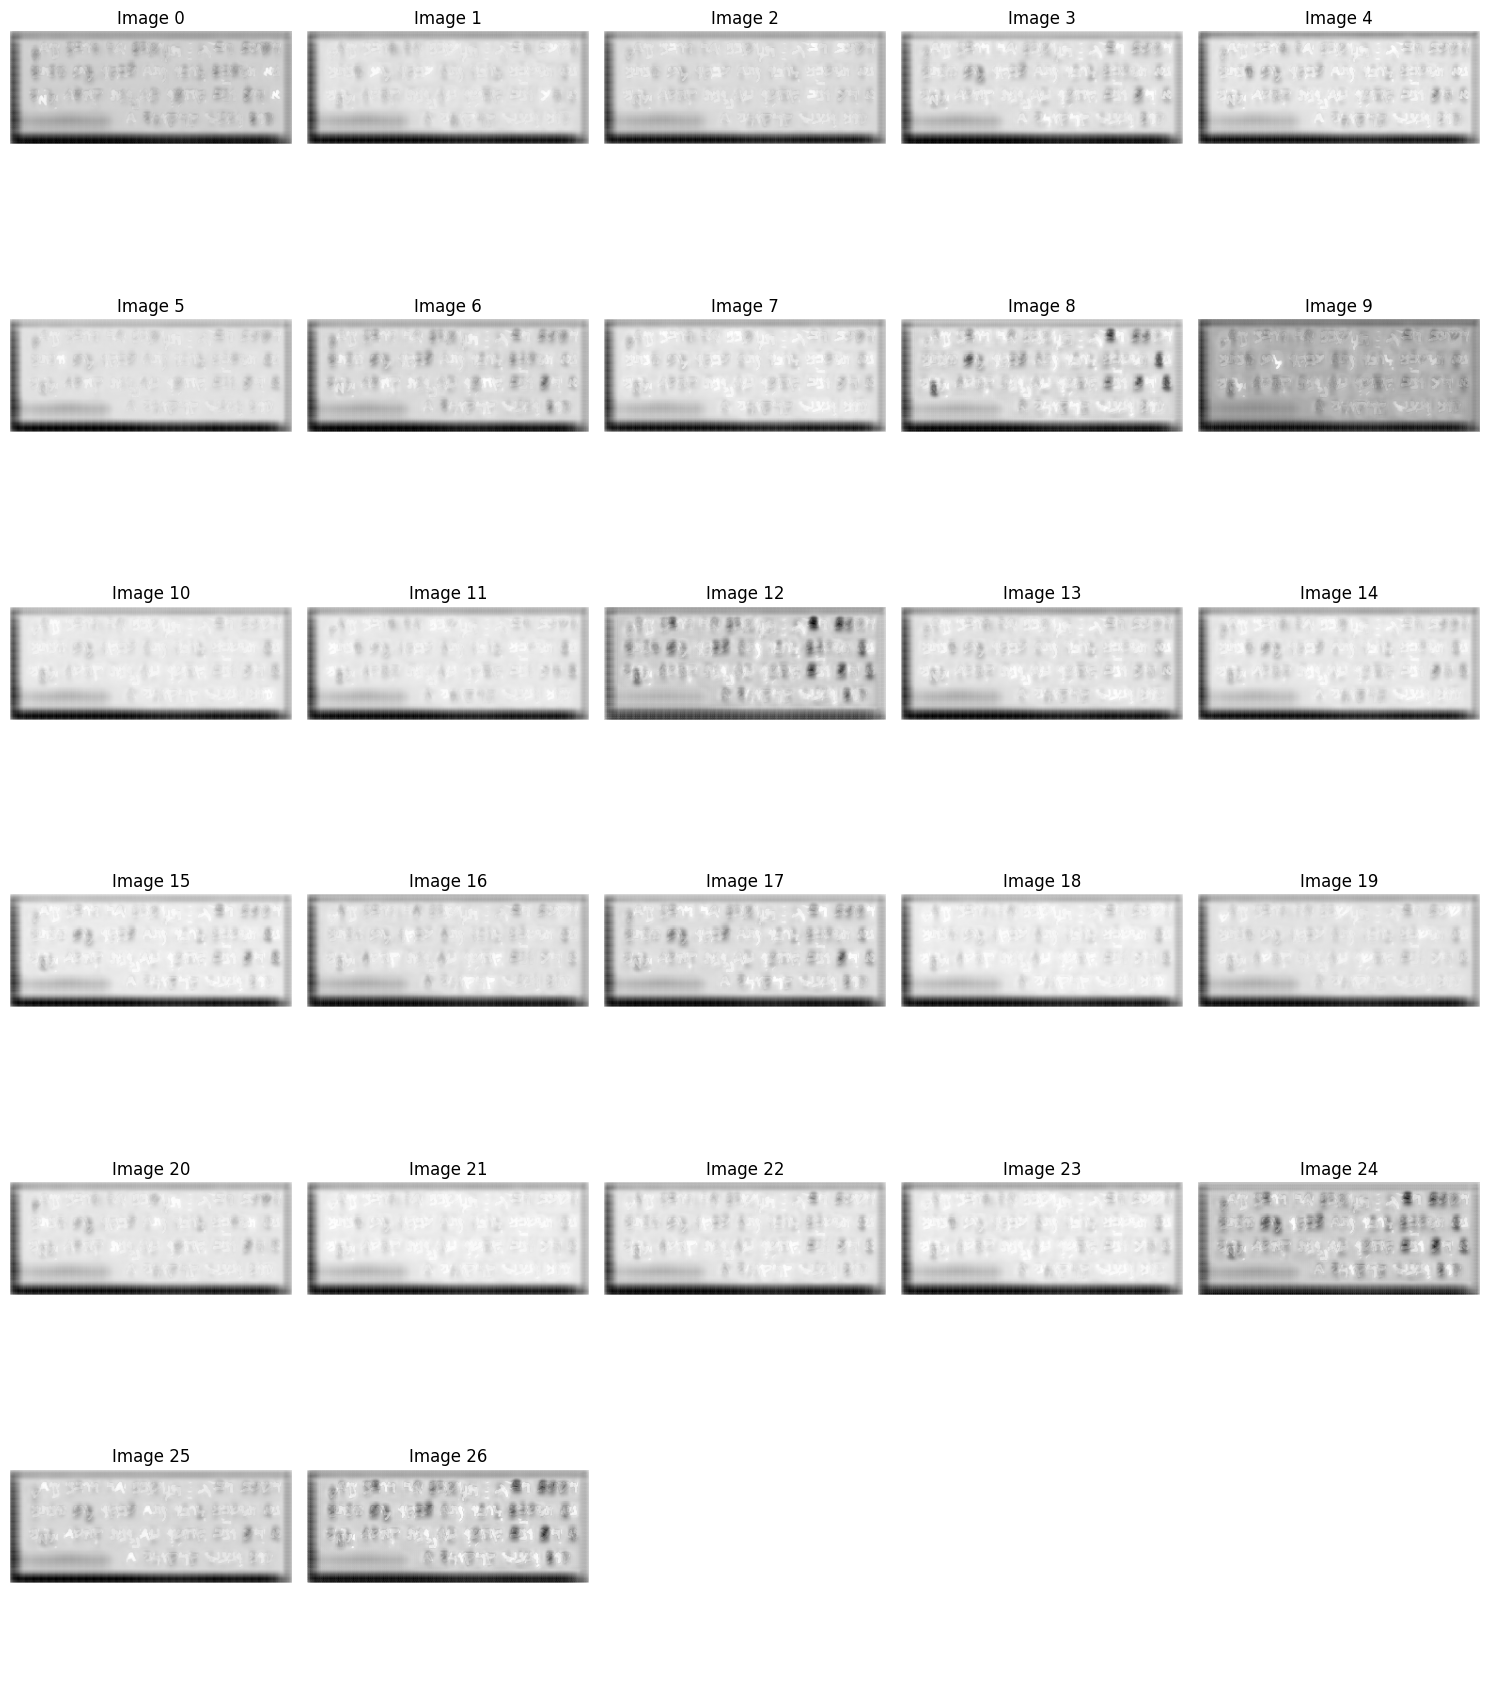

In [17]:
with torch.no_grad():
    output = model(img_tensor)  # Shape: [1, 27, H, W]
    output_np = output.cpu().numpy()  # shape: (27, H, W)

images = output_np[0]
print(images[0])
print(images.shape)
print(images[0].shape)

n = 27
cols = 5
rows = (n + cols - 1) // cols  # ceil division

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))

for i in range(rows * cols):
    ax = axes[i // cols, i % cols]
    if i < n:
        ax.imshow(images[i], cmap='gray')
        ax.set_title(f"Image {i}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [10]:
def get_quantile(raw_masks:np.ndarray, q:float = 0.95) -> np.ndarray:
    """
    raw_masks shape (N,27,120,300)
    """
    raw_masks_flattned = raw_masks.reshape((raw_masks.shape[0], raw_masks.shape[1], -1)) # N,27,36000
    threshold_value = np.quantile(raw_masks_flattned,q,axis=2) # N, 27
    print(threshold_value.shape)
    masks = (raw_masks >= threshold_value[:,:,np.newaxis, np.newaxis]).astype(np.uint8)
    return masks

def jaccard_index(y_trues: np.ndarray, y_preds: np.ndarray) -> float:
    """
    Computes the Jaccard Index between two masks
    """
    intersection = (y_trues & y_preds).sum()
    union = (y_trues | y_preds).sum()
    return intersection / union if union != 0 else 0.0


In [11]:
scrolls.shape


(200, 120, 300)

In [12]:
from torch.utils.data import DataLoader, TensorDataset

#,200, 120, 300
test_dataset = TensorDataset(torch.tensor(scrolls,dtype=torch.float32).unsqueeze(1))
test_dataloader = DataLoader(test_dataset, batch_size=32)
y_hat = []
for (batch,) in test_dataloader:
    with torch.no_grad():
        img_masks = model(batch.to("cuda"))
        print(img_masks.shape)
        img_masks_np = img_masks.cpu().numpy()
        y_hat.append(img_masks_np)

torch.Size([32, 27, 120, 300])
torch.Size([32, 27, 120, 300])
torch.Size([32, 27, 120, 300])
torch.Size([32, 27, 120, 300])
torch.Size([32, 27, 120, 300])
torch.Size([32, 27, 120, 300])
torch.Size([8, 27, 120, 300])


In [13]:
y_hat = np.concat(y_hat, 0)
y_hat.shape

(200, 27, 120, 300)

In [34]:
quantile_masks = get_quantile(y_hat, q=0.993)
quantile_masks.shape

(200, 27)


(200, 27, 120, 300)

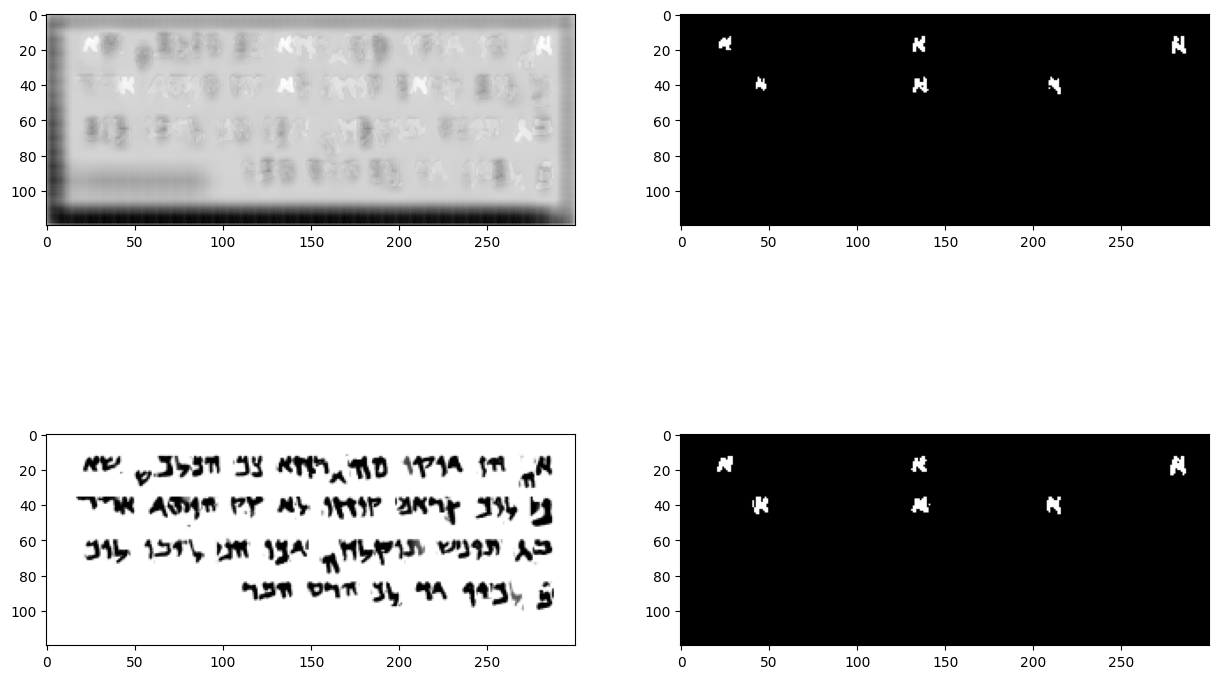

In [35]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
ax[0,0].imshow(y_hat[0,0], cmap="gray")
ax[0,1].imshow(quantile_masks[0,0], cmap="gray")
ax[1,0].imshow(scrolls[0], cmap="gray")
ax[1,1].imshow(masks[0][0], cmap="gray")

In [29]:
jaccard_index(masks, quantile_masks)

np.float64(0.37988924286658)

In [19]:
mask = get_quantile(image=images[0], q = 0.995)
print(masks.shape)
print(mask.shape)
print(images.shape)
fig, ax = plt.subplots(2, 2, figsize=(20,10))
empty_image = np.zeros((scrolls[0].shape[0], scrolls[0].shape[1], 3))
empty_image[:,:,0] = scrolls[0] / 255
empty_image[:,:,1] = mask

ax[0][0].imshow(scrolls[0], cmap='gray')
ax[0][0].set_title('input image')
ax[0][0].axis("off")

ax[0][1].imshow(empty_image, cmap='gray')
ax[0][1].set_title('overlay')
ax[0][1].axis("off")

ax[1][0].imshow(masks[0][0], cmap='gray')
ax[1][0].set_title('ground truth mask')
ax[1][0].axis('off')  

ax[1][1].imshow(mask, cmap='gray')
ax[1][1].set_title('quantile output mask')
ax[1][1].axis('off')




NameError: name 'images' is not defined